In [1]:
import os
import sys
sys.path.append('../sdbm/code')
sys.path.append('../DeepView/deepview')
sys.path.append('../GAN_inverse_projection')
# import make blobs
from sklearn.datasets import make_blobs
# import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import torch as T
import torch.linalg as LA

from ssnp import SSNP
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from tqdm import tqdm

# import warnings
# warnings.filterwarnings('ignore')

from map_evaluation import P_wrapper

In [2]:
import tensorflow as tf
# check GPU
print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices('GPU'))


/device:GPU:0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# %matplotlib widget

In [4]:
X, y = make_blobs(n_samples=200, centers=10, n_features=6, random_state=0)
X = MinMaxScaler().fit_transform(X)
clf = LogisticRegression(random_state=0).fit(X, y)

# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# ssnp = SSNP(bottleneck_activation='linear', verbose=0)
# ssnp.fit(X, y, )

projecter = P_wrapper(deepview=1, ssnp=0, NNinv_Torch=0)
projecter.fit(X, y, clf)

100%|██████████| 200/200 [00:00<00:00, 1399.09it/s]


updating matrices
(0,) (200, 200)
discr 0.00021004676818847656
(0,) (200, 200)
fitting mapper
transforming
fitting inverse
done
fitting time:  4.693290710449219


4.693290710449219

100%|██████████| 200/200 [00:00<00:00, 741.43it/s]


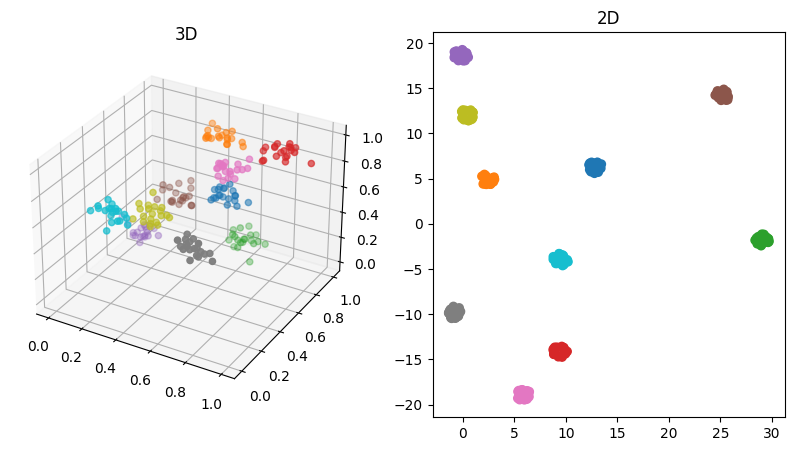

In [5]:
X_2d = projecter.transform(X)
# plot 3d, and 2d
fig0 = plt.figure(figsize=(10, 5))
ax0 = fig0.add_subplot(121, projection='3d')
ax0.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='tab10')
ax0.set_title('3D')
ax = fig0.add_subplot(122)
ax.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap='tab10')
ax.set_title('2D')
plt.show()

In [6]:
class ID_finder_T:
    def __init__(self):
        self.LID_map = None
        self.DM = None
        self.device = T.device('cuda' if T.cuda.is_available() else 'cpu')

    def get_LID(self, X_2d, DM, grid=100, sample_size=5, mode='dim', cmap='jet'):
        self.DM = DM

        pixel_w = (X_2d[:, 0].max() - X_2d[:, 0].min()) / (grid-1)
        pixel_h = (X_2d[:, 1].max() - X_2d[:, 1].min()) / (grid-1)

        xx, yy = np.meshgrid(np.linspace(X_2d[:, 0].min(), X_2d[:, 0].max(), grid),
                            np.linspace(X_2d[:, 1].min(), X_2d[:, 1].max(), grid))
        XY = np.c_[xx.ravel(), yy.ravel()]

        LID_map = np.zeros(XY.shape[0])
        data_shape = DM.inverse_transform(np.zeros((5 ,2)))
        # print(data_shape)
        LID_eval = T.zeros((XY.shape[0], data_shape.shape[1])).to(self.device)

        fig, ax = plt.subplots(figsize=(10, 10))
        ax.scatter(X_2d[:, 0], X_2d[:, 1], c=y , cmap='tab10')
        ax.set_title('2D _debug')

        for i, pix in tqdm(enumerate(XY)):
            ax.scatter(pix[0], pix[1], c='r', marker='+')
            subset = self.get_subset(pix, pixel_w, pixel_h, sample_size)
            ax.scatter(subset[:, 0], subset[:, 1], c='g', marker='x')
            local_cov = self.compute_cov(subset)
            LID_eval[i] = local_cov
            # value = self.process_results(local_cov, mode)
            # LID_map[pix] = value
        LID_map = self.process_results(LID_eval, mode)
        self.LID_map = LID_map.reshape(grid, grid).to('cpu').numpy()
        self.LID_eval = LID_eval.to('cpu').numpy()

    def get_subset(self, center, w, h, n_samples):
        # def sample_uniform_2d(center, size, n_samples):
        """
        Generate `n_samples` uniformly distributed within a square of `size` around `center`.

        Parameters:
        center (tuple): The center of the square (x, y).
        size (float): The size of the square. Points will be generated in the range [center - size/2, center + size/2].
        n_samples (int): The number of samples to generate.

        Returns:
        numpy.ndarray: An array of shape (n_samples, 2) containing the generated points.
        """
        x, y = center
        lower = [x - w/2, y - h/2]
        upper = [x + w/2, y + h/2]

        samples = np.random.uniform(lower, upper, (n_samples, 2))
        return samples

    def compute_cov(self, subset):
        # to cuda, then compute cov
        subset = self.DM.inverse_transform(subset)
        ax0.scatter(subset[:, 0], subset[:, 1], subset[:, 2], c='g', marker='x', s=10)
        subset = T.tensor(subset, dtype=T.float32, device=self.device)
        cov = T.cov(subset.T)
        # subtract the mean
        cov = cov - T.mean(cov, dim=0)
        # comput eigenvalues
        eigvals, eig_vec = LA.eigh(cov)
        # order the eigenvalues
        # eigvals = T.sort(eigvals, descending=True)

        return eigvals

    def process_results(self, LID_eval, mode='dim'):
        ## sort the eigenvalues, 
        LID_eval, ind = T.sort(LID_eval, descending=True)
        # if mode == 'dim', return how many dimensions are needed to explain 95% of the variance; if mode == 'percent', return the percentage of variance explained by the first 2 dimensions
        ### LID_eval: (n_samples, n_features)
        if mode == 'dim':
            # compute the cumulative sum
            cumsum = T.cumsum(LID_eval, dim=1)
            # find the index of the first element that is larger than 0.95
            index = T.argmax((cumsum > 0.95).long(), dim=1)
            # return the number of dimensions
            return index + 1
        elif mode == 'percent':
            # compute the percentage of variance explained by the first 2 dimensions
            return LID_eval[:, 0] / T.sum(LID_eval, dim=1)
                
    
            

    def plot_LID(self, X_2d, DM=None, ax=None, grid=50, cmap='jet', mode='dim', sample_size=5):
        if DM != self.DM or self.LID_map is None:
            self.DM = DM
            # set the others to None
            self.get_LID(X_2d, grid=grid, DM=DM, mode=mode, sample_size=sample_size)

        map = np.flip(self.LID_map, axis=0)
        # map = self.LID_map
        if ax is None:
            plt.imshow(map, cmap=cmap)
            # cbar of this plot
            plt.colorbar()

        else:
            ax.imshow(map, cmap=cmap)
            # ax.colorbar()
            # cbar of this plot
            fig = ax.get_figure()
            cax = fig.add_axes([0.95, 0.1, 0.03, 0.8])
            norm = mpl.colors.Normalize(vmin=map.min(), vmax=map.max())
            mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm)

In [7]:
class ID_finder:
    def __init__(self):
        self.LID_map = None
        self.DM = None
        self.device = T.device('cuda' if T.cuda.is_available() else 'cpu')

    def get_LID(self, X_2d, DM, grid=100, sample_size=5, mode='dim', cmap='jet'):
        self.DM = DM

        pixel_w = (X_2d[:, 0].max() - X_2d[:, 0].min()) / (grid-1)
        pixel_h = (X_2d[:, 1].max() - X_2d[:, 1].min()) / (grid-1)

        xx, yy = np.meshgrid(np.linspace(X_2d[:, 0].min(), X_2d[:, 0].max(), grid),
                            np.linspace(X_2d[:, 1].min(), X_2d[:, 1].max(), grid))
        XY = np.c_[xx.ravel(), yy.ravel()]

        LID_map = np.zeros(XY.shape[0])
        data_shape = DM.inverse_transform(np.zeros((5 ,2)))
        # print(data_shape)
        LID_eval = np.zeros((XY.shape[0], data_shape.shape[1]))

        fig, ax = plt.subplots(figsize=(10, 10))
        ax.scatter(X_2d[:, 0], X_2d[:, 1], c=y , cmap='tab10')
        ax.set_title('2D _debug')

        for i, pix in tqdm(enumerate(XY)):
            ax.scatter(pix[0], pix[1], c='r', marker='+')
            subset = self.get_subset(pix, pixel_w, pixel_h, sample_size)
            ax.scatter(subset[:, 0], subset[:, 1], c='g', marker='x')
            local_cov = self.compute_cov(subset)
            LID_eval[i] = local_cov
            # value = self.process_results(local_cov, mode)
            # LID_map[pix] = value
        print(LID_eval.shape)
        LID_map = self.process_results(LID_eval, mode)
        print(LID_map.shape)
        self.LID_map = LID_map.reshape(grid, grid)#.to('cpu').numpy()
        self.LID_eval = LID_eval#.to('cpu').numpy()

    def get_subset(self, center, w, h, n_samples):
        # def sample_uniform_2d(center, size, n_samples):
        """
        Generate `n_samples` uniformly distributed within a square of `size` around `center`.

        Parameters:
        center (tuple): The center of the square (x, y).
        size (float): The size of the square. Points will be generated in the range [center - size/2, center + size/2].
        n_samples (int): The number of samples to generate.

        Returns:
        numpy.ndarray: An array of shape (n_samples, 2) containing the generated points.
        """
        x, y = center
        lower = [x - w/2, y - h/2]
        upper = [x + w/2, y + h/2]

        samples = np.random.uniform(lower, upper, (n_samples, 2))
        return samples

    def compute_cov(self, subset):
        # to cuda, then compute cov
        subset = self.DM.inverse_transform(subset)
        ax0.scatter(subset[:, 0], subset[:, 1], subset[:, 2], c='g', marker='x', s=10)
        # subset = T.tensor(subset, dtype=T.float32, device=self.device)
        cov = np.cov(subset.T)
        # subtract the mean
        cov = cov - np.mean(cov, axis=0)
        # comput eigenvalues
        eigvals = np.linalg.eigvals(cov)
        # order the eigenvalues
        # eigvals = T.sort(eigvals, descending=True)

        return eigvals

    def process_results(self, LID_eval, mode='dim'):
        ## sort the eigenvalues, 
        # if mode == 'dim', return how many dimensions are needed to explain 95% of the variance; if mode == 'percent', return the percentage of variance explained by the first 2 dimensions
        ### LID_eval: (n_samples, n_features)
        if mode == 'dim':
            # sort the eigenvalues
            LID_eval = np.sort(LID_eval, axis=1)
            # reverse the order
            LID_eval = LID_eval[:, ::-1]
            # cumsum
            LID_eval = np.cumsum(LID_eval, axis=1)
            # find the first value that is greater than 0.95
            LID_eval = np.argmax(LID_eval > 0.95, axis=1)
            # add 1
            LID_eval = LID_eval + 1
        elif mode == 'percent':
            # sort the eigenvalues
            LID_eval = np.sort(LID_eval, axis=1)
            # reverse the order
            LID_eval = LID_eval[:, ::-1]
            # cumsum
            LID_eval = np.cumsum(LID_eval, axis=1)
            # divide by the total sum
            LID_eval = LID_eval / np.sum(LID_eval, axis=1, keepdims=True)
            # find the first value that is greater than 0.95
            LID_eval = LID_eval[:, 1]
        else:
            raise ValueError('mode must be either dim or percent')
        return LID_eval



    def plot_LID(self, X_2d, DM=None, ax=None, grid=50, cmap='jet', mode='dim', sample_size=5):
        if DM != self.DM or self.LID_map is None:
            self.DM = DM
            # set the others to None
            self.get_LID(X_2d, grid=grid, DM=DM, mode=mode, sample_size=sample_size)

        map = np.flip(self.LID_map, axis=0)
        # map = self.LID_map
        if ax is None:
            plt.imshow(map, cmap=cmap)
            # cbar of this plot
            plt.colorbar()

        else:
            ax.imshow(map, cmap=cmap)
            # ax.colorbar()
            # cbar of this plot
            fig = ax.get_figure()
            cax = fig.add_axes([0.95, 0.1, 0.03, 0.8])
            norm = mpl.colors.Normalize(vmin=map.min(), vmax=map.max())
            mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm)

400it [00:07, 50.51it/s]


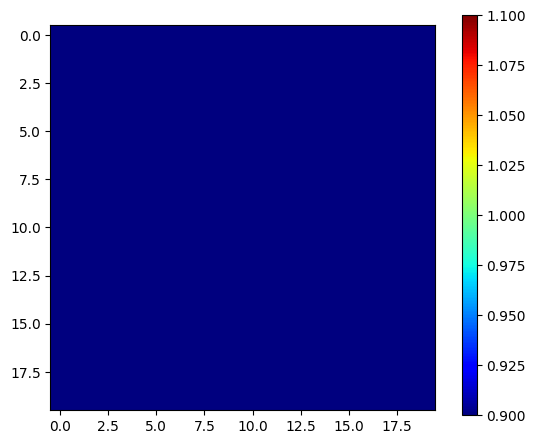

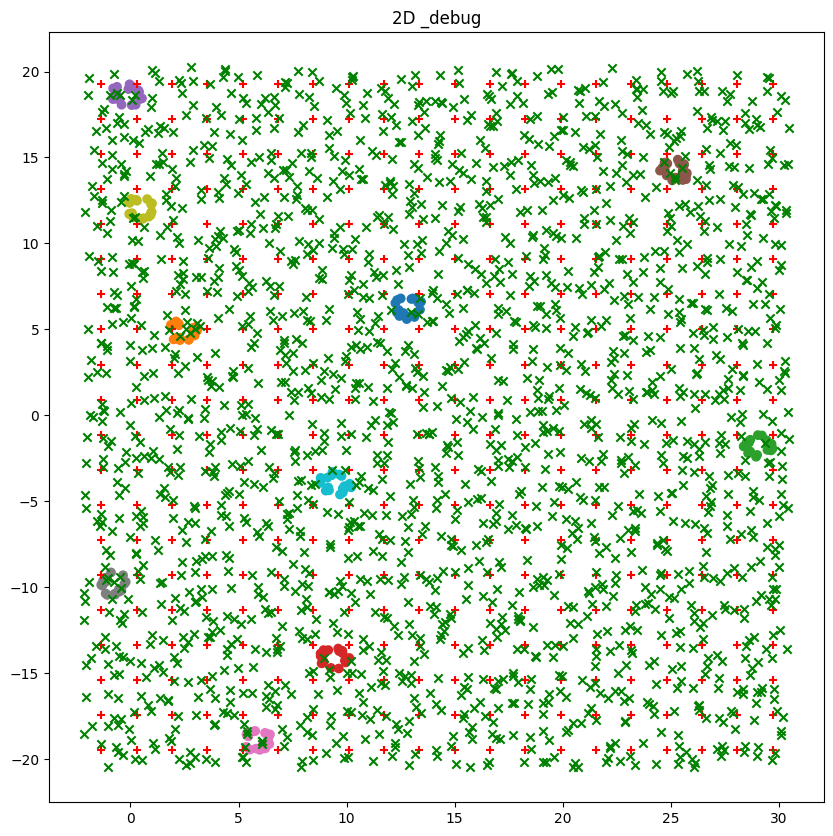

In [8]:
lid_finder = ID_finder_T()
# lid_finder.get_LID(ssnp, grid=10, mode='dim')
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

lid_finder.plot_LID(X_2d, DM=projecter, grid=20, mode='dim', ax=ax, sample_size=5)


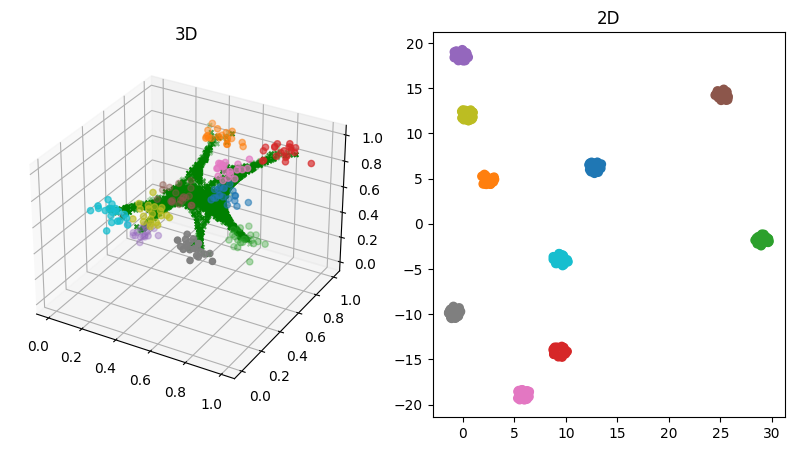

In [9]:

fig0

In [10]:
lid_finder.LID_map

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1,

In [11]:
lid_finder.LID_eval[8:18]

array([[-1.89317492e-04, -1.19258875e-05, -1.05565359e-05,
         3.17544109e-05,  9.04373010e-05,  2.79477768e-04],
       [-1.36471601e-04, -6.62686080e-06, -3.26274608e-06,
         3.03437355e-05,  8.89563089e-05,  1.51840984e-04],
       [-3.66954155e-05, -3.12103293e-06, -7.30533884e-07,
         9.81473204e-06,  4.99963498e-05,  6.44150205e-05],
       [-9.78206936e-06, -2.12319264e-06, -4.43528080e-07,
         2.69456177e-06,  5.40586097e-06,  1.24236874e-04],
       [-2.08547644e-05, -1.73253011e-05,  2.21926666e-06,
         4.51721235e-06,  6.66277992e-06,  6.04062516e-05],
       [-3.50482151e-05, -2.41873167e-05,  3.93746677e-06,
         7.31189630e-06,  1.07322912e-05,  1.01459867e-04],
       [-6.89420558e-05, -3.10105024e-05,  4.77681260e-06,
         1.32219539e-05,  2.37709082e-05,  2.43735398e-04],
       [-3.73573166e-05, -1.56958995e-05,  3.15722559e-06,
         7.45377974e-06,  1.44035503e-05,  1.47100698e-04],
       [-5.63997201e-05, -1.79985018e-05,  3.871